In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
plt.style.use('ggplot')


#import matplotlib.font_manager as fm
#path = 'C:\Windows\Fonts\malgunbd.ttf'
#font_name = fm.FontProperties(fname=path).get_name()
#plt.rc('font', family=font_name)
import matplotlib as mpl
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()


import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.float_format = '{:.2f}'.format

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784',version = 1)

In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [5]:
X,y = mnist['data'], mnist['target']

In [6]:
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

이미지 70,000개, 각 이미지에는 784개의 특성이 존재.. (28x 28픽셀이기 때문)
개개의 특성은 단순히 0(흰색) 부터 255(검은색)까지의 픽셀 강도를 나타냅니다.

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [9]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

샘플의특성 벡터를 추출해서 28 x 28배열로 크기를 바꾸고 imshow하자

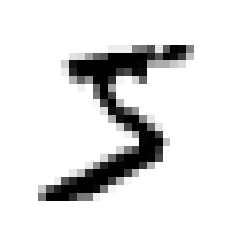

In [10]:
plt.imshow(some_digit_image,cmap = 'binary')
plt.axis('off')
plt.show()

In [11]:
y[0]

'5'

In [12]:
# 대부분 머신러닝 알고리즘은 숫자를 기대하므로 y를 정수로 변환
y = y.astype(np.uint8)

In [13]:
# Mninst 데이터는 이미 훈련세트와 테스트 세트를 구분지어놈
X_train, X_test, y_train, y_test = X[:60000], X[60000:],y[:60000],y[60000:]

### 3.2 이진 분류기 훈련

문제를 단순화해서 하나의 숫자,,,5를 식별하는지 마는지 감지기 생성

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

##### 확률적 경사하강법인 SGDClassifier사용.

이 분류기는 매우 큰 데이터셋을 효율적으로 처리하는 장점 지님. 
이유는 SGD가 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문. 그래서 온라인 학습에 잘 맞음

In [15]:
from sklearn.linear_model import SGDClassifier

In [16]:
# SGDClassifier은 훈련하는데 무작위성을 사용합니다. 재현성을 위해 Seed값 지정해주어야!
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [17]:
# 숫자 5를 감지해보자!
sgd_clf.predict([some_digit])

array([ True])

분류기는 이 이미지가 5를 나타낸다고 <b>추측</b>했습니다. 이 경우엔 특별하게 정확히 맞춘 것 같습니다.

### 3.3 성능 측정

#####  3.3.1 교차 검증을 사용한 정확도 측정

직접 구현

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [19]:
skfolds = StratifiedKFold(n_splits = 3, random_state=42,shuffle=True)

In [20]:
for train_index ,test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


StratifiedKFold : 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행.<br>
매 반복에서 분류기 객체를 복제, 훈련 폴드로 훈련시키고 테스트 폴드로 예측,,<br>
그 다음 올바른 예측의 수를 세어 정확한 예측의 비율ㅇ르 출력

cross_val_score이용

In [21]:
from sklearn.model_selection import cross_val_score,cross_val_predict
cross_val_score(sgd_clf,X_train,y_train_5,cv = 3, scoring ='accuracy')

array([0.95035, 0.96035, 0.9604 ])

모든 교차 검증 폴드에 대해 정확도가 95%이상.... <br>
모든 이미지를 '5아님' 클래스로 분류하는 더미 분류기를 만들어 비교해보겠다

In [22]:
from sklearn.base import BaseEstimator

In [23]:
class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self,X):
        return np.zeros((len(X),1),dtype =bool)

##### 의미

이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여줍니다. 
<br>
특히 <b> 불균형한 데이터 셋</b>를 다룰 때 더욱 그렇습니다

### 3.3.2 오차 행렬

In [24]:
from sklearn.model_selection import cross_val_predict

In [25]:
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv = 3)

In [26]:
from sklearn.metrics import confusion_matrix

In [27]:
confusion_matrix(y_train_5,y_train_pred) # 입력 순서는 실제 , 예측

array([[53892,   687],
       [ 1891,  3530]])

오차 행렬의 행 : 실제 클래스, 열은 예측한 클래스<br>
1행 : "5 아님"을 의미( 음성 클래스).. 
2행 : "5 맞음"을 의미( 양성 클래스)..

In [28]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5,y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### 3.3.3 정밀도와 재현율

In [29]:
from sklearn.metrics import precision_score,recall_score

In [30]:
precision_score(y_train_5,y_train_pred) # 정밀도(예측의 정확도)

0.8370879772350012

In [31]:
recall_score(y_train_5,y_train_pred) # 재현율

0.6511713705958311

In [32]:
# F1 score : 정밀도와 재현율을 조화평균 낸 식
from sklearn.metrics import f1_score

In [33]:
f1_score(y_train_5,y_train_pred)

0.7325171197343846

### 3.3.4 정밀도/재현율 트레이드오프

사이킷런에서 임계값을 직접 정할 수는 없지만 예측에 사용한 점수는 확인할 수 있습니다. 분류기의 predict() 메서드 대신 deciscion_function()메서드를 호출하면 각 샘플의 점수를 얻을 수 있습니다. dl 점수를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있습니다.

In [34]:
y_scores = sgd_clf.decision_function([some_digit])

In [35]:
y_scores

array([2164.22030239])

In [36]:
threshold = 0
y_some_digit_pred = (y_scores> threshold)

In [37]:
y_some_digit_pred

array([ True])

사실 predict()메서드도 decision_function()함수를 사용하여 0보다 큰 경우를 양성으로 예측

임계값을 높이면 재현율이 줄어든다는 것을 보여줍니다. 이미지가 실제로 숫자 5이고, 임계값이 0일때는 분류기가 이를 감지했지만, 임계값을 8000으로 높이면 이를 놓치게 됩니다.

In [38]:
threshold = 8000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

##### 그렇다면 적절한 임계값을 어떻게 정할 수 있을까요?

이를 위해서는 먼저 cross_val_predict()함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야합니다. 하지만 이번에는 예측 결과가 아니라 결정 점수를 반환받도록 지정해야합니다!<br>
method라는 파라미터에 decision_function입력

In [39]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv = 3,method = 'decision_function')

이 점수로 precision_recall_curve()함수를 사용하여 가능한 모든 임계값에 대해 정밀도와 재현율을 계산할 수 있습니다.

In [40]:
from sklearn.metrics import precision_recall_curve

In [41]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

In [42]:
thresholds

array([-106527.45300471, -105763.22240074, -105406.2965229 , ...,
         38871.26391927,   42216.05562787,   49441.43765905])

In [43]:
precisions

array([0.09040123, 0.09038606, 0.09038757, ..., 1.        , 1.        ,
       1.        ])

In [44]:
recalls

array([1.00000000e+00, 9.99815532e-01, 9.99815532e-01, ...,
       3.68935621e-04, 1.84467810e-04, 0.00000000e+00])

이제 맷플롯립을 이용해 임계값의 함수로 정밀도와 재현율을 그릴 수 있습니다.

In [45]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],label = '정밀도')
    plt.plot(thresholds,recalls[:-1],label = '재현율')
    plt.legend(loc = 'center right', fontsize= 16)
    plt.xlabel('Threshold',fontsize = 16)
    plt.grid(True)
    plt.axis([-50000,50000,0,1])

In [46]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


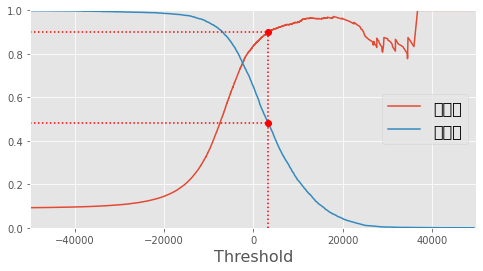

In [47]:
plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

재현율과 정밀도의 그래프

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


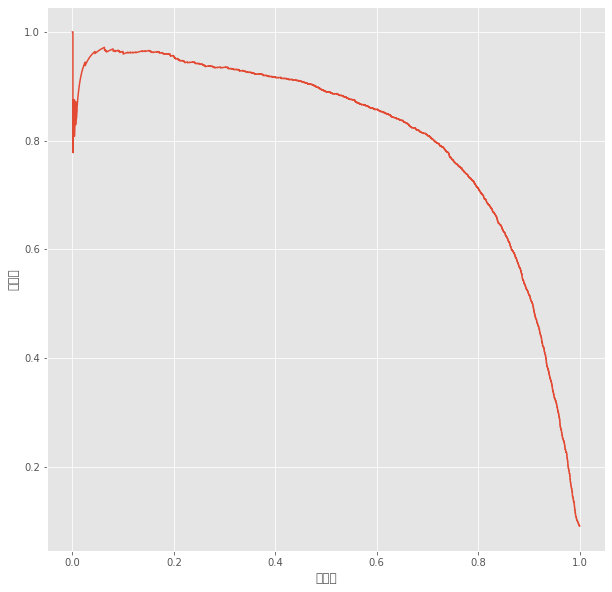

In [48]:
plt.figure(figsize = (10,10))
plt.plot(recalls,precisions)
plt.xlabel('재현율')
plt.ylabel('정밀도')
plt.show()

재현율이 90% 근처에서 정밀도가 급격하게 줄어들기 시작합니다.

이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋습니다. 예를 들면 재현율이 60%정도인 지점입니다. 물론 이런 선택은 프로젝트에 따라 달라집니다

정밀도 90% 달성하는 것을 목표라고 가정. 최소한 정밀도가 90% 되는 가장 낮은 임계값을 찾자

np.argmax()는 최대값의 첫 번째 인덱스를 반환합니다! 여기서는 첫번째 True

In [49]:
threshold_90_precision

3370.0194991439557

(훈련 세트에 대한) 예측을 만들려면 분류기의 predict()메서드 대신 아래 코드 실행!

In [50]:
y_train_pred_90 = (y_scores>= threshold_90_precision)

이 예측에 대한 정밀도와 재현율을 확인!

In [51]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [52]:
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

### 3.3.5 ROC곡선

In [53]:
from sklearn.metrics import roc_curve

In [54]:
fpr, tpr, thresholds = roc_curve(y_train_5,y_scores)

In [55]:
def plot_roc_curve(fpr,tpr,label = None):
    plt.plot(fpr,tpr,linewidth = 2,label = label)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('거짓 양성 비율(FPR)')
    plt.ylabel('진짜 양성 비율(TPR,재현율)')

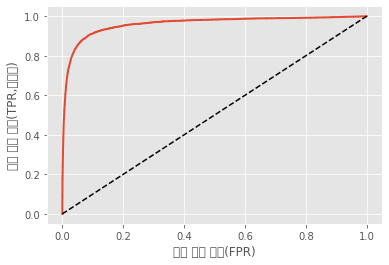

In [56]:
plot_roc_curve(fpr,tpr)
plt.show()

여기에서도 트레이드오프가 있습니다. 재현율(TPR)이 높을수록 분류기가 만드는 거짓양성(FPR)이 늘어납니다. 점선은 완전한 랜덤 분류기의 ROC곡선을 뜻합니다.

곡선 아래 면적을 측정하면 분류기들을 비교할 수 있습니다. 완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤분류기는 0.5입니다. ROC의 AUC계산하는 함수는 아래입니다.

In [57]:
from sklearn.metrics import roc_auc_score

In [58]:
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

RandomForestClassifier과 비교

랜덤포레스트는 decision_function()메서드 대신 predict_proba()메서드 가지고 있음.<br>
사이킷런 분류기는 일반적으로 이 두 메서드 중 하나 또는 둘 모두를 가지고 있습니다.<br>
predict_proba() 메서드는 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환합니다.

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv = 3,method = 'predict_proba')

In [61]:
y_probas_forest # (음성클래스, 양성클래스)

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

양성 클래스 확률을 점수로 사용해보겠다!

In [62]:
y_score_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds = roc_curve(y_train_5,y_score_forest)

ROC곡선 그릴 때 비교를 위해 첫 번째 ROC곡선도 함께 그리겠습니다.

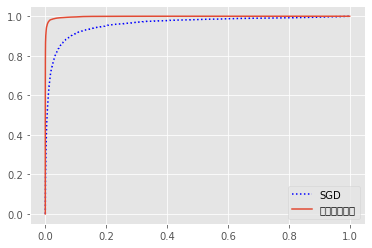

In [63]:
plt.plot(fpr,tpr,'b:',label = "SGD")
plt.plot(fpr_forest,tpr_forest,label = '랜덤포레스트')
plt.legend(loc = 'lower right')
plt.show()

In [64]:
roc_auc_score(y_train_5,y_score_forest)

0.9983436731328145

In [65]:
y_train_predict = cross_val_predict(forest_clf,X_train,y_train_5,cv = 3)

In [66]:
precision_score(y_train_5,y_train_predict)

0.9905083315756169

In [67]:
recall_score(y_train_5,y_train_predict)

0.8662608374838591

## 다중 분류

2 이상의 클래스 분류하는 것!!

In [68]:
from sklearn.svm import SVC

In [69]:
svm_clf = SVC()
svm_clf.fit(X_train,y_train) # 다중 분류이므로~ 전체!

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [70]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

내부에서는 사이킷런이 OvO전략을 사용해 45개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 가장 높은 클래스를 선택합니다

In [71]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [72]:
np.argmax(some_digit_scores)

5

In [73]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

사이킷런에서 OvO나 OvR을 사용하도록 강제할 수 있습니다.

In [76]:
from sklearn.multiclass import OneVsRestClassifier

In [77]:
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [78]:
len(ovr_clf.estimators_)

10

SGDClassifier를 훈련시키는 것도 간단합니다. 이 경우 SGD분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 사이킷런의 OvR이나 OvO를 적용할 필요가 없습니다.

In [79]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [80]:
# SGD분류기가 클래스마다 부여한 점수 비교
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

책과 상이하게 결과 나옴.. 그래도 분류기 평가해보자

In [81]:
cross_val_score(sgd_clf,X_train,y_train,cv = 3,scoring = 'accuracy')

array([0.87365, 0.85835, 0.8689 ])

모든 테스트 폴드에서 84%이상을 얻었습니다. 성능을 더 높일 여지가 있습니다. 입력의 스케일을 조정해보자

In [82]:
from sklearn.preprocessing import StandardScaler

In [83]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv = 3,scoring = 'accuracy')

array([0.8983, 0.891 , 0.9018])

**3.5 에러분석**

In [84]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv = 3)
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

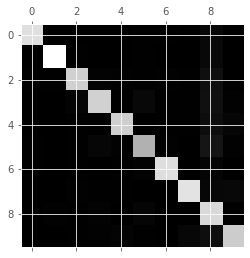

In [85]:
plt.matshow(conf_mx,cmap = plt.cm.gray)
plt.show()

배열에서 가장 큰 값은 흰색,, 가장 작은 값은 검은색..

그래프의 에러 부부네 초점을 맞춰보겠습니다. 먼저 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 (에러의 절대 개수가 아님!!) 에러 비율을 비교합니다.
(개수로 배교하면 이미지가 많은 클래스가 상대적으로 나쁘게 보입니다.)

In [87]:
row_sums = conf_mx.sum(axis = 1,keepdims = True)
norm_conf_mx = conf_mx / row_sums

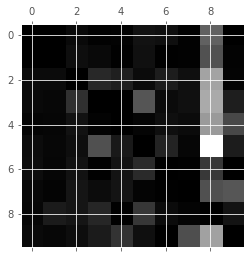

In [89]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap = plt.cm.gray)
plt.show()

행 : 실제 클래스 / 열 : 예측한 클래스
클래스 8의 열은 상당히 밝으므로 많은 이미지가 8로 잘못 분류되었음을 암시.. 하지만 클래스 8의 행은 그리 나쁘지 않다! 이는 실제 8이 적절히 8로 분류되었다는 것을 말해준다.

또한, 여기서 오차 행렬은 반드시 대칭인 것은 아니라는 것을 보여준다. 3과 5가 서로 많이 혼동되고 있는 것을 볼 수 있다.

In [96]:
cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [94]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

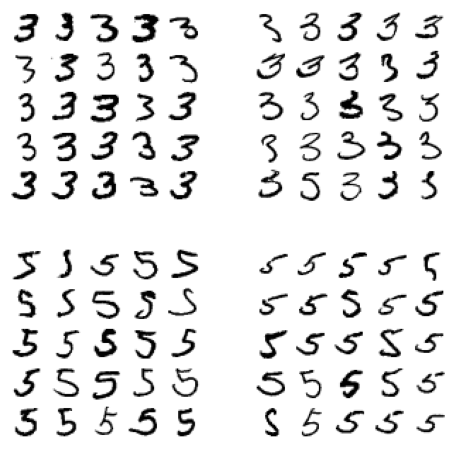

In [97]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()